## Loading Packages

In [ ]:
import numpy as np
from scipy.special import gammaln, gamma
import time
import matplotlib.pyplot as plt

## Simulation Class

In [6]:
class simulations:
    def __init__(self):
        pass

    def generate_simplex_sample_dirichlet(self, sample_size, dimensions, alpha=1):
        return np.random.dirichlet([alpha] * dimensions, sample_size)
    
    def generate_simplex_sample_gamma(self, sample_size, dimensions, alpha=1):
        gamma_samples = np.random.gamma(alpha, 1, (sample_size, dimensions))
        simplex_sample = gamma_samples / np.sum(gamma_samples, axis=1, keepdims=True)
        return simplex_sample
    
    def sample_generator(self, sample_size, dimensions, draw_function, alpha):
        return draw_function(sample_size, dimensions, alpha)

    def dirichlet_density(self, x, alpha):
        alpha = np.array(alpha)
        # Use gammaln to prevent overflow in gamma calculations
        log_B = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
        B = np.exp(log_B)

        # Compute the density
        density = np.prod(x ** (alpha - 1), axis=1) / B
        
        # Add a small constant to avoid NaN
        density = np.where(np.isfinite(density), density, 0)  # Replace NaNs and Infs with 0

        return density

    def gamma_density(self, x, alpha):
        gamma_samples = x * np.sum(alpha)  # Approximation for gamma density normalization
        return np.prod(gamma_samples ** (alpha - 1) * np.exp(-gamma_samples), axis=1)

    def importance_sampling_integration(self, sample_size, dimensions, objective_function, proposal_function, proposal_density, alpha):
        sample = self.sample_generator(sample_size=sample_size, dimensions=dimensions, draw_function=proposal_function, alpha=alpha)
        proposal_values = proposal_density(sample)
        target_values = objective_function(sample)
        weights = target_values / proposal_values
        # Add a small constant to avoid NaN
        weights = np.where(np.isfinite(weights), weights, 0)  # Replace NaNs and Infs with 0
        approx_integral = np.mean(weights)
        return approx_integral, weights
    
    # Define the objective function
def objective_function(x, alpha, sigma=None):
    return np.prod(np.power(x, alpha), axis=1) * np.exp(-sigma * np.sum(x ** 2, axis=1))


## Running

In [21]:

# Initialize simulation class
sim = simulations()

# Set parameters
dimensions = 5
alpha_vals = np.array([.6] *  dimensions)
alpha_vals[3] = alpha_vals[3] 
alpha_prop = np.array([2] *  dimensions)
alpha_prop_s = 2
sigma = 500
sample_size = 10000000

# Wrapping objective function for Dirichlet and Gamma
obj_funct_dirichlet = lambda s: objective_function(x=s, alpha=alpha_vals, sigma=sigma)
obj_funct_gamma = lambda s: objective_function(x=s, alpha=alpha_vals, sigma=sigma)

# Perform importance sampling with Dirichlet and Gamma proposals
dirichlet_result, _ = sim.importance_sampling_integration(
    sample_size=sample_size,
    dimensions=dimensions,
    objective_function=obj_funct_dirichlet,
    proposal_function=sim.generate_simplex_sample_dirichlet,
    proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
    alpha = alpha_prop_s
)

gamma_result, weights_g = sim.importance_sampling_integration(
    sample_size=sample_size,
    dimensions=dimensions,
    objective_function=obj_funct_gamma,
    proposal_function=sim.generate_simplex_sample_gamma,
    proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
    alpha = alpha_prop_s
)

# Output results for comparison
print(f"Dirichlet result: {dirichlet_result}")
print(f"Gamma result: {gamma_result}")

Dirichlet result: 5.086695372490338e-51
Gamma result: 5.096683046027606e-51


In [ ]:
# Initialize simulation class
sim = simulations()

# Set parameters
dimensions = 5
alpha_vals = np.array([1] * dimensions)
alpha_prop = np.array([2] * dimensions)
alpha_prop_s = 2
sigma = 500
max_sample_size = 22000000  # Replace with your max sample size
interval = 100000  # Step size
time_threshold = 7  # In seconds, adjust as needed

# Wrapping objective function for Dirichlet and Gamma
obj_funct_gamma = lambda s: objective_function(x=s, alpha=alpha_vals, sigma=sigma)

# Storage for sample sizes and times
results_0 = []
sample_size = 0

# Loop over sample sizes
while sample_size <= max_sample_size:
    start_time = time.time()
    
    # Compute gamma result with current sample size
    gamma_result, weights_g = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha=alpha_prop_s
    )
    
    # Record computation time
    elapsed_time = time.time() - start_time
    results_0.append((sample_size, gamma_result, elapsed_time))
    
    # Print results for the current iteration
    print(f"Sample size: {sample_size}, Gamma result: {gamma_result}, Time: {elapsed_time:.4f}s")

    # Increment sample size
    sample_size += interval

# Final output: list of results
print("Final results:", results_0)

Sample size: 0, Gamma result: nan, Time: 0.0025s
Sample size: 100000, Gamma result: 1.9546239688038254e-52, Time: 0.0302s
Sample size: 200000, Gamma result: 1.933143701225302e-52, Time: 0.0524s
Sample size: 300000, Gamma result: 1.9495971302788176e-52, Time: 0.0772s
Sample size: 400000, Gamma result: 2.065123820328123e-52, Time: 0.1007s
Sample size: 500000, Gamma result: 2.0037081182679538e-52, Time: 0.1272s
Sample size: 600000, Gamma result: 2.0379437251886643e-52, Time: 0.1538s
Sample size: 700000, Gamma result: 1.9521577254905876e-52, Time: 0.1779s
Sample size: 800000, Gamma result: 2.0031105116520245e-52, Time: 0.2017s
Sample size: 900000, Gamma result: 2.024488052459914e-52, Time: 0.2285s
Sample size: 1000000, Gamma result: 1.994080803600413e-52, Time: 0.2566s
Sample size: 1100000, Gamma result: 2.019132756470872e-52, Time: 0.2839s
Sample size: 1200000, Gamma result: 2.0252901666502162e-52, Time: 0.3070s
Sample size: 1300000, Gamma result: 2.030543316056431e-52, Time: 0.3311s
Samp

In [ ]:
# Initialize simulation class
sim = simulations()

# Set parameters
dimensions = 5
alpha_vals = np.array([1, 2 , 1 , 1, 1])
alpha_prop = np.array([2] * dimensions)
alpha_prop_s = 2
sigma = 500
max_sample_size = 22000000  # Replace with your max sample size
interval = 100000  # Step size
time_threshold = 7  # In seconds, adjust as needed

# Wrapping objective function for Dirichlet and Gamma
obj_funct_gamma = lambda s: objective_function(x=s, alpha=alpha_vals, sigma=sigma)

# Storage for sample sizes and times
results_1 = []
sample_size = 0

# Loop over sample sizes
while sample_size <= max_sample_size:
    start_time = time.time()
    
    # Compute gamma result with current sample size
    gamma_result, weights_g = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha=alpha_prop_s
    )
    
    # Record computation time
    elapsed_time = time.time() - start_time
    results_1.append((sample_size, gamma_result, elapsed_time))
    
    # Print results for the current iteration
    print(f"Sample size: {sample_size}, Gamma result: {gamma_result}, Time: {elapsed_time:.4f}s")

    # Increment sample size
    sample_size += interval

# Final output: list of results
print("Final results:", results_1)

Sample size: 0, Gamma result: nan, Time: 0.0068s
Sample size: 100000, Gamma result: 3.903167530780513e-53, Time: 0.0357s
Sample size: 200000, Gamma result: 4.02144090504534e-53, Time: 0.0541s
Sample size: 300000, Gamma result: 4.058458667371121e-53, Time: 0.0806s
Sample size: 400000, Gamma result: 3.964487623975527e-53, Time: 0.1165s
Sample size: 500000, Gamma result: 4.0831357268809107e-53, Time: 0.1415s
Sample size: 600000, Gamma result: 3.923341116146637e-53, Time: 0.1772s
Sample size: 700000, Gamma result: 4.075498927366071e-53, Time: 0.2051s
Sample size: 800000, Gamma result: 3.9401472196878366e-53, Time: 0.2303s
Sample size: 900000, Gamma result: 3.9679227420153203e-53, Time: 0.2444s
Sample size: 1000000, Gamma result: 3.972476867073546e-53, Time: 0.2922s
Sample size: 1100000, Gamma result: 4.038885101190694e-53, Time: 0.3243s
Sample size: 1200000, Gamma result: 3.9454942930819532e-53, Time: 0.3417s
Sample size: 1300000, Gamma result: 3.9718403484310246e-53, Time: 0.3590s
Sample 

In [40]:
ratio_times = [results_0[i][2] + results_1[i][2] for i in range(1,len(results_1))]
ratio_result = [results_1[i][1] / results_0[i][1] - 1.99997e-1 for i in range(1,len(results_1))]

# ESS

In [138]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 2
alpha_prop = np.array([2, 2, 2, 2, 2])
sigma = 10

w_5_10_2= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_10_2.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.9435239830663289, ESS2 : 99999.99999940144, Weights_variance : 5.985647206351995e-12
Sample Size: 200000, ESS : 0.942229884120108, ESS2 : 199999.99999969345, Weights_variance : 1.5328031103004238e-12
Sample Size: 300000, ESS : 0.943364569774608, ESS2 : 299999.9999997999, Weights_variance : 6.670618954984353e-13
Sample Size: 400000, ESS : 0.94303523974781, ESS2 : 399999.999999849, Weights_variance : 3.775359992606432e-13
Sample Size: 500000, ESS : 0.9428938493453946, ESS2 : 499999.99999987887, Weights_variance : 2.4225908651011456e-13
Sample Size: 600000, ESS : 0.9421453458862311, ESS2 : 599999.9999998977, Weights_variance : 1.705759872825969e-13
Sample Size: 700000, ESS : 0.9424337204083256, ESS2 : 699999.9999999128, Weights_variance : 1.2465831888677832e-13
Sample Size: 800000, ESS : 0.9427534597979241, ESS2 : 799999.9999999241, Weights_variance : 9.487922652112744e-14
Sample Size: 900000, ESS : 0.9431496968797989, ESS2 : 899999.9999999331, Weights_varianc

In [139]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 3
alpha_prop = np.array([3, 3, 3, 3, 3])
sigma = 10

w_5_10_3= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_10_3.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.49441919776573995, ESS2 : 99999.99998977425, Weights_variance : 1.0225751842140404e-10
Sample Size: 200000, ESS : 0.3583289343459387, ESS2 : 199999.99999104635, Weights_variance : 4.476829835311165e-11
Sample Size: 300000, ESS : 0.46412276898540206, ESS2 : 299999.99999615137, Weights_variance : 1.2828914790657528e-11
Sample Size: 400000, ESS : 0.20758000330747542, ESS2 : 399999.99999045645, Weights_variance : 2.3858873207513477e-11
Sample Size: 500000, ESS : 0.3990261736150544, ESS2 : 499999.99999698775, Weights_variance : 6.024405075389491e-12
Sample Size: 600000, ESS : 0.4512175463785701, ESS2 : 599999.999997973, Weights_variance : 3.3784051988638925e-12
Sample Size: 700000, ESS : 0.4619744608969269, ESS2 : 699999.9999983363, Weights_variance : 2.3767792318220084e-12
Sample Size: 800000, ESS : 0.33777445978435816, ESS2 : 799999.9999975493, Weights_variance : 3.0633678083521493e-12
Sample Size: 900000, ESS : 0.45782258786428365, ESS2 : 899999.9999986843, W

In [140]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 4
alpha_prop = np.array([4, 4, 4, 4, 4])
sigma = 10

w_5_10_4= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_10_4.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.07885070406344004, ESS2 : 99999.99988317805, Weights_variance : 1.1682194938873863e-09
Sample Size: 200000, ESS : 0.09168495398497045, ESS2 : 199999.99995046546, Weights_variance : 2.476728750291802e-10
Sample Size: 300000, ESS : 0.10815975251064122, ESS2 : 299999.9999725147, Weights_variance : 9.161759206355593e-11
Sample Size: 400000, ESS : 0.05448748694799865, ESS2 : 399999.9999566179, Weights_variance : 1.0845523509305588e-10
Sample Size: 500000, ESS : 0.006189688382931162, ESS2 : 499999.99967888196, Weights_variance : 6.422360869459117e-10
Sample Size: 600000, ESS : 0.025243738573082028, ESS2 : 599999.9999356437, Weights_variance : 1.072605103203166e-10
Sample Size: 700000, ESS : 0.006743794881340603, ESS2 : 699999.9997895937, Weights_variance : 3.0058053595945637e-10
Sample Size: 800000, ESS : 0.08958751080329497, ESS2 : 799999.9999872971, Weights_variance : 1.5878547150319218e-11
Sample Size: 900000, ESS : 0.03276957630476725, ESS2 : 899999.999967204

In [141]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 5
alpha_prop = np.array([5, 5, 5, 5, 5])
sigma = 10

w_5_10_5= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_10_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.012392067516896605, ESS2 : 99999.99920303216, Weights_variance : 7.969678434502538e-09
Sample Size: 200000, ESS : 0.007600495447723079, ESS2 : 199999.99934714814, Weights_variance : 3.2642592557883053e-09
Sample Size: 300000, ESS : 0.02299769931365709, ESS2 : 299999.9998583913, Weights_variance : 4.720290047574715e-10
Sample Size: 400000, ESS : 0.03827196330700052, ESS2 : 399999.9999371781, Weights_variance : 1.570549224536852e-10
Sample Size: 500000, ESS : 0.012881512197701905, ESS2 : 499999.9998467387, Weights_variance : 3.0652254879777314e-10
Sample Size: 600000, ESS : 0.03239858706332574, ESS2 : 599999.9999502241, Weights_variance : 8.295984319774135e-11
Sample Size: 700000, ESS : 0.0021263509432954005, ESS2 : 699999.9993295867, Weights_variance : 9.577331725183071e-10
Sample Size: 800000, ESS : 0.00889857112354104, ESS2 : 799999.999860778, Weights_variance : 1.7402748835964005e-10
Sample Size: 900000, ESS : 0.009884614665579505, ESS2 : 899999.999888703

In [194]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 6
alpha_prop = np.array([6, 6, 6, 6, 6])
sigma = 100

w_5_100_6= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_100_6.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.6204632146441028, ESS2 : 99999.999993883, Weights_variance : 6.116990925458792e-11
Sample Size: 200000, ESS : 0.6949338157086533, ESS2 : 199999.99999780508, Weights_variance : 1.0974648858476461e-11
Sample Size: 300000, ESS : 0.748313396760579, ESS2 : 299999.9999988789, Weights_variance : 3.737094412417791e-12
Sample Size: 400000, ESS : 0.7503332324807472, ESS2 : 399999.99999916815, Weights_variance : 2.0796323945779202e-12
Sample Size: 500000, ESS : 0.6238850991182608, ESS2 : 499999.9999987943, Weights_variance : 2.4114369867996756e-12
Sample Size: 600000, ESS : 0.732974429677974, ESS2 : 599999.9999993929, Weights_variance : 1.0119557590362796e-12
Sample Size: 700000, ESS : 0.7162524115131573, ESS2 : 699999.9999994341, Weights_variance : 8.084813424561897e-13
Sample Size: 800000, ESS : 0.6713083837850504, ESS2 : 799999.999999388, Weights_variance : 7.650442966913774e-13
Sample Size: 900000, ESS : 0.6420646256205773, ESS2 : 899999.9999993804, Weights_varian

In [142]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 8
alpha_prop = np.array([8, 8, 8, 8, 8])
sigma = 100

w_5_100_8= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_100_8.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.7895170362384121, ESS2 : 99999.99999733402, Weights_variance : 2.6659711456565447e-11
Sample Size: 200000, ESS : 0.5148708098440257, ESS2 : 199999.99999528885, Weights_variance : 2.355586978716753e-11
Sample Size: 300000, ESS : 0.4458839246578885, ESS2 : 299999.99999585754, Weights_variance : 1.380817953081163e-11
Sample Size: 400000, ESS : 0.3138647994631807, ESS2 : 399999.99999453477, Weights_variance : 1.3663032651924333e-11
Sample Size: 500000, ESS : 0.6120770657048145, ESS2 : 499999.99999873247, Weights_variance : 2.5351247810501607e-12
Sample Size: 600000, ESS : 0.6281412309591999, ESS2 : 599999.9999990134, Weights_variance : 1.6444407311648453e-12
Sample Size: 700000, ESS : 0.5279252463253432, ESS2 : 699999.9999987225, Weights_variance : 1.8249134159582015e-12
Sample Size: 800000, ESS : 0.525408041575536, ESS2 : 799999.999998871, Weights_variance : 1.4113791117748171e-12
Sample Size: 900000, ESS : 0.24514770809261183, ESS2 : 899999.9999965788, Weight

In [143]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 10
alpha_prop = np.array([10, 10, 10, 10, 10])
sigma = 100

w_5_100_10= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_100_10.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.06001942997376655, ESS2 : 99999.99984338728, Weights_variance : 1.5661271198961446e-09
Sample Size: 200000, ESS : 0.4111885016433702, ESS2 : 199999.99999284014, Weights_variance : 3.5799365498023743e-11
Sample Size: 300000, ESS : 0.329620627929117, ESS2 : 299999.99999322067, Weights_variance : 2.2597674594801936e-11
Sample Size: 400000, ESS : 0.31151934892614985, ESS2 : 399999.9999944748, Weights_variance : 1.3812959240074838e-11
Sample Size: 500000, ESS : 0.44975381018557037, ESS2 : 499999.99999755307, Weights_variance : 4.893754559521315e-12
Sample Size: 600000, ESS : 0.4766837827499469, ESS2 : 599999.9999981703, Weights_variance : 3.0495188039373008e-12
Sample Size: 700000, ESS : 0.3504940245296517, ESS2 : 699999.9999973527, Weights_variance : 3.7818687513941895e-12
Sample Size: 800000, ESS : 0.27880053143872874, ESS2 : 799999.9999967664, Weights_variance : 4.041865213856798e-12
Sample Size: 900000, ESS : 0.1519063706939602, ESS2 : 899999.9999937968, Wei

In [193]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 14
alpha_prop = np.array([14, 14, 14, 14, 14])
sigma = 100

w_5_100_14= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_100_14.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.13915628388862109, ESS2 : 99999.99993813835, Weights_variance : 6.186164879197167e-10
Sample Size: 200000, ESS : 0.024103376574689823, ESS2 : 199999.99979756022, Weights_variance : 1.0121990796613822e-09
Sample Size: 300000, ESS : 0.08407975514230201, ESS2 : 299999.99996368843, Weights_variance : 1.2103854955697652e-10
Sample Size: 400000, ESS : 0.05428368838126793, ESS2 : 399999.9999564457, Weights_variance : 1.088858757367845e-10
Sample Size: 500000, ESS : 0.14221191513064704, ESS2 : 499999.9999879364, Weights_variance : 2.4127038415348554e-11
Sample Size: 600000, ESS : 0.09931978822178504, ESS2 : 599999.9999848858, Weights_variance : 2.5190241763050178e-11
Sample Size: 700000, ESS : 0.08852641267694042, ESS2 : 699999.9999852914, Weights_variance : 2.1012374973315316e-11
Sample Size: 800000, ESS : 0.10635728831316461, ESS2 : 799999.9999894971, Weights_variance : 1.31285477390067e-11
Sample Size: 900000, ESS : 0.0628783893474672, ESS2 : 899999.9999834403, 

In [145]:
# Initialize simulation class
sim = simulations() 

# Set parameters
dimensions = 5
alpha_vals = np.array([.6, .6, .6, .6, .6])
alpha_prop_s = 8
alpha_prop = np.array([18, 18, 18, 18, 18])
sigma = 100

w_5_100_18= []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_5_100_18.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 2.886681284249691e-05, ESS2 : 99999.65359263087, Weights_variance : 3.464085691216413e-06
Sample Size: 200000, ESS : 9.668467192769244e-06, ESS2 : 199999.48286128198, Weights_variance : 2.585700275946195e-06
Sample Size: 300000, ESS : 5.037339803031952e-06, ESS2 : 299999.338279862, Weights_variance : 2.205738658722438e-06
Sample Size: 400000, ESS : 2.522528697151863e-06, ESS2 : 399999.0089359529, Weights_variance : 2.4776662565830822e-06
Sample Size: 500000, ESS : 1.099173834058993e-05, ESS2 : 499999.8180472254, Weights_variance : 3.6390568162232647e-07
Sample Size: 600000, ESS : 4.1626080621956904e-06, ESS2 : 599999.5996119279, Weights_variance : 6.673138987561535e-07
Sample Size: 700000, ESS : 1.9070910915228647e-06, ESS2 : 699999.2509182274, Weights_variance : 1.0701179632055897e-06
Sample Size: 800000, ESS : 2.066170670018937e-06, ESS2 : 799999.3950178026, Weights_variance : 7.562283185415699e-07
Sample Size: 900000, ESS : 1.2627627995674245e-06, ESS2 : 8

In [146]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([1.5] * 25)
alpha_prop_s = 1.5
sigma = 10

w_25_10_1_5 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_10_1_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.9161213003337475, Time: 9.155850828454189e-12 seconds
Sample Size: 200000, Normalization Constant: 0.9160384878720232, Time: 2.291429706273058e-12 seconds
Sample Size: 300000, Normalization Constant: 0.9161802193683972, Time: 1.0165367863418231e-12 seconds
Sample Size: 400000, Normalization Constant: 0.9160699035099001, Time: 5.726234439678319e-13 seconds
Sample Size: 500000, Normalization Constant: 0.9154991124323353, Time: 3.6920139591685033e-13 seconds
Sample Size: 600000, Normalization Constant: 0.9156988715689725, Time: 2.5572795650175825e-13 seconds
Sample Size: 700000, Normalization Constant: 0.915743479505233, Time: 1.8777319903526428e-13 seconds
Sample Size: 800000, Normalization Constant: 0.9159095889509583, Time: 1.4345440734452444e-13 seconds
Sample Size: 900000, Normalization Constant: 0.9157769185083495, Time: 1.1354196731887488e-13 seconds
Sample Size: 1000000, Normalization Constant: 0.9158732827734237, Time: 9.185410122656

In [147]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([2] * 25)
alpha_prop_s = 2
sigma = 10

w_25_10_2 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_10_2.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.4551970145704192, Time: 1.196850963409162e-10 seconds
Sample Size: 200000, Normalization Constant: 0.44182802750931666, Time: 3.158310121458473e-11 seconds
Sample Size: 300000, Normalization Constant: 0.4503047227601973, Time: 1.3563538186378411e-11 seconds
Sample Size: 400000, Normalization Constant: 0.4442911930387008, Time: 7.817350642837486e-12 seconds
Sample Size: 500000, Normalization Constant: 0.4480055383422766, Time: 4.928461051622082e-12 seconds
Sample Size: 600000, Normalization Constant: 0.44041885894391636, Time: 3.5293494520566426e-12 seconds
Sample Size: 700000, Normalization Constant: 0.46066754815800226, Time: 2.3893119399185884e-12 seconds
Sample Size: 800000, Normalization Constant: 0.4545942201294599, Time: 1.8746312498320565e-12 seconds
Sample Size: 900000, Normalization Constant: 0.4598142171842515, Time: 1.4503597393126271e-12 seconds
Sample Size: 1000000, Normalization Constant: 0.4558526302180791, Time: 1.193691411

In [148]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([2.5] * 25)
alpha_prop_s = 2.5
sigma = 10

w_25_10_2_5 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_10_2_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.0005628851461024469, Time: 1.775561358785609e-07 seconds
Sample Size: 200000, Normalization Constant: 0.023912376508353244, Time: 1.0204837055307665e-09 seconds
Sample Size: 300000, Normalization Constant: 0.026450130798242846, Time: 4.089666267218242e-10 seconds
Sample Size: 400000, Normalization Constant: 0.01367976701430611, Time: 4.506291261915378e-10 seconds
Sample Size: 500000, Normalization Constant: 0.02271158304718001, Time: 1.7212158481822158e-10 seconds
Sample Size: 600000, Normalization Constant: 0.012498564519084173, Time: 2.1946996703614568e-10 seconds
Sample Size: 700000, Normalization Constant: 0.02539137717556014, Time: 7.83335687420724e-11 seconds
Sample Size: 800000, Normalization Constant: 0.0206808323220135, Time: 7.399055200829921e-11 seconds
Sample Size: 900000, Normalization Constant: 0.024006715748687287, Time: 5.019137116342389e-11 seconds
Sample Size: 1000000, Normalization Constant: 0.021639604840981166, Time: 4

In [149]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([3] * 25)
alpha_prop_s = 3
sigma = 10

w_25_10_3 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_10_3.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.006674932129897661, Time: 1.4881425736464108e-08 seconds
Sample Size: 200000, Normalization Constant: 0.001593903968329953, Time: 1.5659759243177162e-08 seconds
Sample Size: 300000, Normalization Constant: 0.001846938198500839, Time: 6.004851480452595e-09 seconds
Sample Size: 400000, Normalization Constant: 0.0011660769284757664, Time: 5.3536022081812084e-09 seconds
Sample Size: 500000, Normalization Constant: 0.0013260402973892655, Time: 3.0124995798960845e-09 seconds
Sample Size: 600000, Normalization Constant: 0.00116090766327247, Time: 2.3899859756697014e-09 seconds
Sample Size: 700000, Normalization Constant: 0.00024496266634759325, Time: 8.329091257631082e-09 seconds
Sample Size: 800000, Normalization Constant: 0.002699912955268687, Time: 5.771598610120069e-10 seconds
Sample Size: 900000, Normalization Constant: 0.0011250069965720766, Time: 1.096152297243893e-09 seconds
Sample Size: 1000000, Normalization Constant: 0.0020887984582614

In [150]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([2] * 25)
alpha_prop_s = 2
sigma = 100

w_25_100_2 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_2.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.7369702507511775, Time: 3.5690687511568064e-11 seconds
Sample Size: 200000, Normalization Constant: 0.7350718340608682, Time: 9.010281501181633e-12 seconds
Sample Size: 300000, Normalization Constant: 0.7341701417513071, Time: 4.023134316803457e-12 seconds
Sample Size: 400000, Normalization Constant: 0.7297867854756449, Time: 2.314145205680182e-12 seconds
Sample Size: 500000, Normalization Constant: 0.7261767941553553, Time: 1.5083005022937381e-12 seconds
Sample Size: 600000, Normalization Constant: 0.731550912911945, Time: 1.0193301592772219e-12 seconds
Sample Size: 700000, Normalization Constant: 0.730160371874345, Time: 7.542084449340079e-13 seconds
Sample Size: 800000, Normalization Constant: 0.7308122471582832, Time: 5.755320404805514e-13 seconds
Sample Size: 900000, Normalization Constant: 0.7296448077617621, Time: 4.574442779813646e-13 seconds
Sample Size: 1000000, Normalization Constant: 0.7312782940810405, Time: 3.6746845639203315

In [156]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([2.5] * 25)
alpha_prop_s = 2.5
sigma = 100

w_25_100_2_5 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_2_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.10504570806528941, Time: 8.519665471515187e-10 seconds
Sample Size: 200000, Normalization Constant: 0.025232633752577786, Time: 9.657804411200624e-10 seconds
Sample Size: 300000, Normalization Constant: 0.1144577374600281, Time: 8.596499189146155e-11 seconds
Sample Size: 400000, Normalization Constant: 0.0636233612989014, Time: 9.198435719841353e-11 seconds
Sample Size: 500000, Normalization Constant: 0.1002469588335206, Time: 3.5901459820270154e-11 seconds
Sample Size: 600000, Normalization Constant: 0.11258879280554521, Time: 2.189410748326542e-11 seconds
Sample Size: 700000, Normalization Constant: 0.0413853028467268, Time: 4.7271770175226053e-11 seconds
Sample Size: 800000, Normalization Constant: 0.07764452396412531, Time: 1.8561263019294593e-11 seconds
Sample Size: 900000, Normalization Constant: 0.06910379598604856, Time: 1.663084576553152e-11 seconds
Sample Size: 1000000, Normalization Constant: 0.10251442595650262, Time: 8.7547246

In [154]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([3] * 25)
alpha_prop_s = 3
sigma = 100

w_25_100_3 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_3.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.007252225316357809, Time: 1.3688871089601186e-08 seconds
Sample Size: 200000, Normalization Constant: 0.007174933649678457, Time: 3.459352778805188e-09 seconds
Sample Size: 300000, Normalization Constant: 0.009863808953549734, Time: 1.115341272895424e-09 seconds
Sample Size: 400000, Normalization Constant: 0.00041181394413865584, Time: 1.517050661292241e-08 seconds
Sample Size: 500000, Normalization Constant: 0.006554467640148729, Time: 6.062707679107909e-10 seconds
Sample Size: 600000, Normalization Constant: 0.0029874577973439593, Time: 9.270354501270328e-10 seconds
Sample Size: 700000, Normalization Constant: 0.0011442051527263944, Time: 1.781569685398433e-09 seconds
Sample Size: 800000, Normalization Constant: 0.0011421747417066747, Time: 1.3664418367665963e-09 seconds
Sample Size: 900000, Normalization Constant: 0.007094982922052664, Time: 1.727711929015541e-10 seconds
Sample Size: 1000000, Normalization Constant: 0.012583088403504899

In [155]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([3.5] * 25)
alpha_prop_s = 3.5
sigma = 100

w_25_100_3_5 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_3_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.004453051339192852, Time: 2.2356511812443145e-08 seconds
Sample Size: 200000, Normalization Constant: 0.0032871589394217137, Time: 7.580351752294056e-09 seconds
Sample Size: 300000, Normalization Constant: 0.0014347026566790297, Time: 7.733428190733145e-09 seconds
Sample Size: 400000, Normalization Constant: 0.0025046039837783654, Time: 2.489154479302732e-09 seconds
Sample Size: 500000, Normalization Constant: 0.0002448562992094078, Time: 1.6332112294906048e-08 seconds
Sample Size: 600000, Normalization Constant: 9.569947560125383e-05, Time: 2.902327236853447e-08 seconds
Sample Size: 700000, Normalization Constant: 0.0014657954965407104, Time: 1.3902518543406642e-09 seconds
Sample Size: 800000, Normalization Constant: 0.0007359712213326848, Time: 2.1214824706588382e-09 seconds
Sample Size: 900000, Normalization Constant: 0.0005860959228627256, Time: 2.105191791805292e-09 seconds
Sample Size: 1000000, Normalization Constant: 0.0005372668438

In [151]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([4] * 25)
alpha_prop_s = 4
sigma = 100

w_25_100_4 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_4.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.0015855116863510486, Time: 6.297112136785539e-08 seconds
Sample Size: 200000, Normalization Constant: 0.00028743354436661106, Time: 8.695162638885806e-08 seconds
Sample Size: 300000, Normalization Constant: 7.013868603836624e-05, Time: 1.5840518863298819e-07 seconds
Sample Size: 400000, Normalization Constant: 0.00029579958358363044, Time: 2.1122921056567628e-08 seconds
Sample Size: 500000, Normalization Constant: 0.00030487966614046915, Time: 1.3115930399546745e-08 seconds
Sample Size: 600000, Normalization Constant: 0.0008879403633543721, Time: 3.1255604444922045e-09 seconds
Sample Size: 700000, Normalization Constant: 3.410470310966282e-05, Time: 5.983769213687987e-08 seconds
Sample Size: 800000, Normalization Constant: 0.000151412843465173, Time: 1.031790554670764e-08 seconds
Sample Size: 900000, Normalization Constant: 0.0004858282441702843, Time: 2.5399266676770103e-09 seconds
Sample Size: 1000000, Normalization Constant: 8.274608691

In [152]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([6] * 25)
alpha_prop_s = 6
sigma = 100

w_25_100_6 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_6.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 6.268733940079091e-05, Time: 1.5951184437219603e-06 seconds
Sample Size: 200000, Normalization Constant: 1.3498543247027244e-05, Time: 1.8520267023572667e-06 seconds
Sample Size: 300000, Normalization Constant: 6.503699323019196e-05, Time: 1.708318285645354e-07 seconds
Sample Size: 400000, Normalization Constant: 8.693962651599145e-05, Time: 7.188271767172556e-08 seconds
Sample Size: 500000, Normalization Constant: 0.0003978602206709342, Time: 1.0049782188263446e-08 seconds
Sample Size: 600000, Normalization Constant: 2.1787025272591518e-05, Time: 1.274941036469789e-07 seconds
Sample Size: 700000, Normalization Constant: 4.629889929138346e-05, Time: 4.4077113499776634e-08 seconds
Sample Size: 800000, Normalization Constant: 8.780701762135672e-06, Time: 1.7794549028999965e-07 seconds
Sample Size: 900000, Normalization Constant: 4.385329640725548e-05, Time: 2.8150991202527065e-08 seconds
Sample Size: 1000000, Normalization Constant: 4.48796088

In [153]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([8] * 25)
alpha_prop_s = 8
sigma = 100

w_25_100_8 = []

for sample_size in range(100000, 10000000, 100000):

    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_8.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 3.958568995291979e-05, Time: 2.5260653925681847e-06 seconds
Sample Size: 200000, Normalization Constant: 0.00017561302978860545, Time: 1.4233345728585064e-07 seconds
Sample Size: 300000, Normalization Constant: 8.221876500845042e-05, Time: 1.3512970631626226e-07 seconds
Sample Size: 400000, Normalization Constant: 1.9227081296318785e-05, Time: 3.2505608804694137e-07 seconds
Sample Size: 500000, Normalization Constant: 5.05192719276809e-06, Time: 7.917730481185982e-07 seconds
Sample Size: 600000, Normalization Constant: 8.406532230615534e-06, Time: 3.3042809449812424e-07 seconds
Sample Size: 700000, Normalization Constant: 4.541093944882436e-06, Time: 4.4940868516755195e-07 seconds
Sample Size: 800000, Normalization Constant: 1.9820757370356097e-05, Time: 7.882993575227521e-08 seconds
Sample Size: 900000, Normalization Constant: 0.00013761102080341213, Time: 8.9701973277915e-09 seconds
Sample Size: 1000000, Normalization Constant: 3.785018435

In [130]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * dimensions)
alpha_prop = np.array([2] * dimensions)
alpha_prop_s = 2
sigma = 10

w_25_10_2 = []

for sample_size in range(100000, 10000000, 100000):
    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = (((np.sum(normalized_weights))**2) / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_10_2.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, ESS : {ess}, ESS2 : {ess2}, Weights_variance : {weights_variance}")

Sample Size: 100000, ESS : 0.4334866274623168, ESS2 : 99999.99998693123, Weights_variance : 1.3068762371151346e-10
Sample Size: 200000, ESS : 0.4639462792470961, ESS2 : 199999.9999942229, Weights_variance : 2.8885549078161872e-11
Sample Size: 300000, ESS : 0.43327761113810426, ESS2 : 299999.99999564, Weights_variance : 1.45332121252666e-11
Sample Size: 400000, ESS : 0.4567889691491246, ESS2 : 399999.999997027, Weights_variance : 7.432467007997314e-12
Sample Size: 500000, ESS : 0.4524704266369982, ESS2 : 499999.99999757984, Weights_variance : 4.840356771447223e-12
Sample Size: 600000, ESS : 0.4485616483030793, ESS2 : 599999.9999979511, Weights_variance : 3.4148554718238874e-12
Sample Size: 700000, ESS : 0.45681109283934196, ESS2 : 699999.9999983013, Weights_variance : 2.4267116265358793e-12
Sample Size: 800000, ESS : 0.4497975611704531, ESS2 : 799999.9999984709, Weights_variance : 1.911284953244516e-12
Sample Size: 900000, ESS : 0.447897493774368, ESS2 : 899999.9999986303, Weights_varia

In [128]:
# Set parameters
dimensions = 25
alpha_vals = np.array([.6] * 25)
alpha_prop = np.array([2] * 25)
alpha_prop_s = 2.5
sigma = 100

w_25_100_2_5 = []

for sample_size in range(100000, 10000000, 100000):


    # Compute the normalization constant
    gamma_result, weights = sim.importance_sampling_integration(
        sample_size=sample_size,
        dimensions=dimensions,
        objective_function=obj_funct_gamma,
        proposal_function=sim.generate_simplex_sample_gamma,
        proposal_density=lambda x: sim.dirichlet_density(x, alpha_prop),
        alpha = alpha_prop_s
    )

    # Stop timer
    elapsed_time = time.time() - start_time
    
    # Normalize the weights
    normalized_weights = weights / np.sum(weights)

    # compute the ess
    ess = ((np.sum(normalized_weights))**2 / np.sum(normalized_weights**2)) / sample_size

    # Compute the variance of the normalized weights
    mean_weight = 1 / sample_size
    weights_variance = np.var(normalized_weights - mean_weight)

    # other ess formula
    ess2 = sample_size / (1 + weights_variance)

    # Storing the ess and weights variance
    w_25_100_2_5.append({
        'sample_size': sample_size,
        'ess': ess,
        'ess2': ess2,
        'weights_variance': weights_variance
    })

    # Print out the results for each iteration
    print(f"Sample Size: {sample_size}, Normalization Constant: {ess}, Time: {weights_variance} seconds")

Sample Size: 100000, Normalization Constant: 0.8609963824229888, Time: 1.614450657572243e-11 seconds
Sample Size: 200000, Normalization Constant: 0.8575095704014096, Time: 4.154193565789856e-12 seconds
Sample Size: 300000, Normalization Constant: 0.8584327351085944, Time: 1.8323737499427035e-12 seconds
Sample Size: 400000, Normalization Constant: 0.8595091269069873, Time: 1.021592359340183e-12 seconds
Sample Size: 500000, Normalization Constant: 0.8585358188312734, Time: 6.590950689107087e-13 seconds
Sample Size: 600000, Normalization Constant: 0.8580914047394983, Time: 4.593805976997909e-13 seconds
Sample Size: 700000, Normalization Constant: 0.8588932282577315, Time: 3.35283821179732e-13 seconds
Sample Size: 800000, Normalization Constant: 0.8589417512165672, Time: 2.5659890605148126e-13 seconds
Sample Size: 900000, Normalization Constant: 0.8585055788034757, Time: 2.034750558714551e-13 seconds
Sample Size: 1000000, Normalization Constant: 0.8577014181875596, Time: 1.6590689812911415

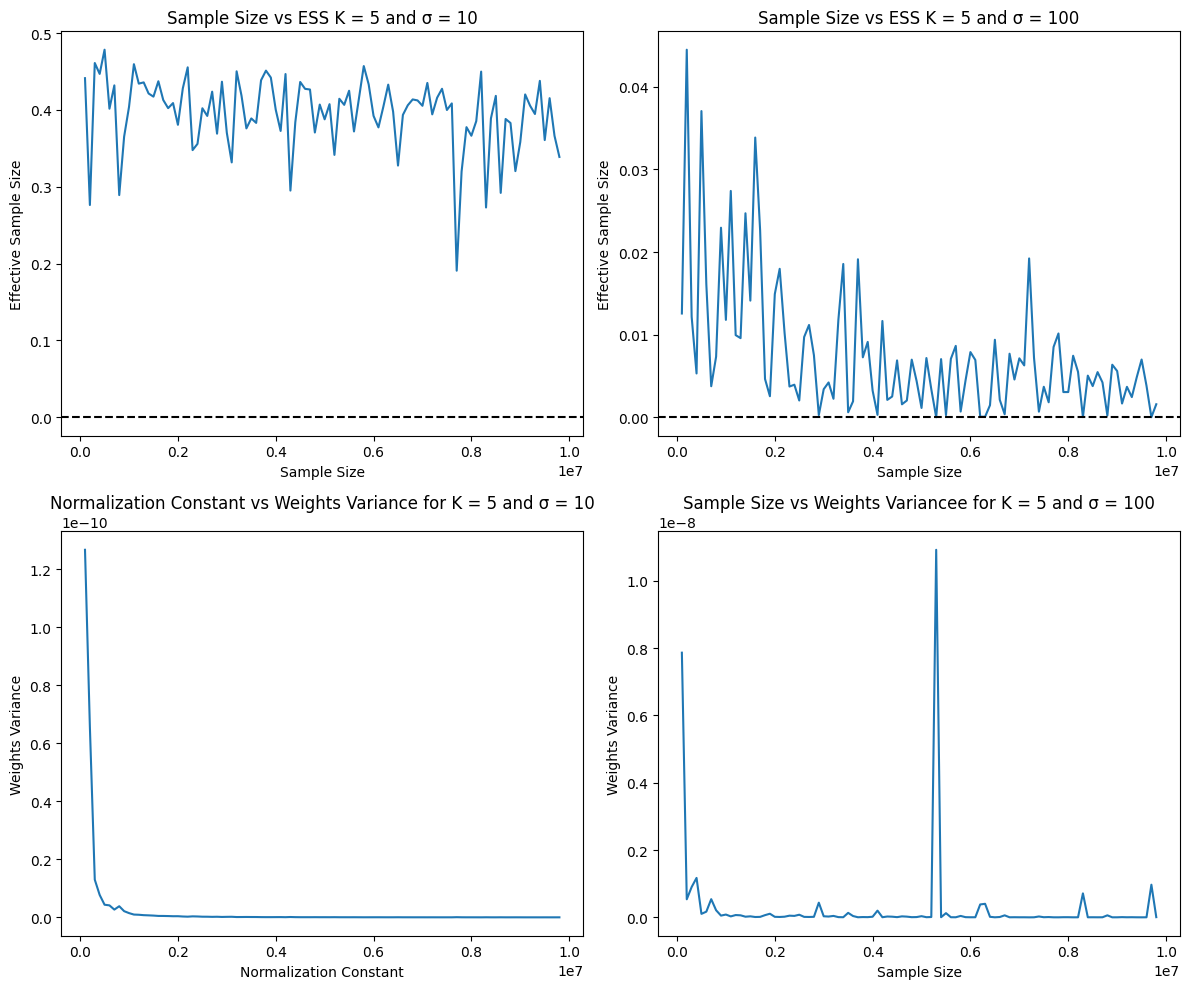

In [ ]:
# Sample data for sigma = 10
s_5_10 = [w_5_10[i]['sample_size'] for i in range(98)]
e_5_10 = [w_5_10[i]['ess']  for i in range(98)]
w_5_10 = [w_5_10[i]['weights_variance'] for i in range(98)]

s_5_100 = [w_5_100[i]['sample_size'] for i in range(98)]
e_5_100 = [w_5_100[i]['ess']  for i in range(98)]
w_5_100 = [w_5_100[i]['weights_variance'] for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Upper left plot: Sample size vs Execution time
axs[0, 0].plot(s_5_10, e_5_10)
axs[0, 0].set_title('Sample Size vs ESS K = 5 and \u03C3 = 10')
axs[0, 0].set_xlabel('Sample Size')
axs[0, 0].set_ylabel('Effective Sample Size')
axs[0, 0].grid(False)
axs[0, 0].axhline(y=0, color='black', linestyle='--')  

# Upper right plot: Sample size vs Normalization constant
axs[0, 1].plot(s_5_100, e_5_100)
axs[0, 1].set_title('Sample Size vs ESS K = 5 and \u03C3 = 100')
axs[0, 1].set_xlabel('Sample Size')
axs[0, 1].set_ylabel('Effective Sample Size')
axs[0, 1].grid(False)
axs[0, 1].axhline(y=0, color='black', linestyle='--')  


# Lower left plot: Normalization constant vs Execution time
axs[1, 0].plot(s_5_10, w_5_10)
axs[1, 0].set_title('Normalization Constant vs Weights Variance for K = 5 and \u03C3 = 10')
axs[1, 0].set_xlabel('Normalization Constant')
axs[1, 0].set_ylabel('Weights Variance')
axs[1, 0].grid(False)

# Lower right plot: Sample size vs Sample size (placeholder)
axs[1, 1].plot(s_5_100, w_5_100)
axs[1, 1].set_title('Sample Size vs Weights Variancee for K = 5 and \u03C3 = 100')
axs[1, 1].set_xlabel('Sample Size')
axs[1, 1].set_ylabel('Weights Variance')
axs[1, 1].grid(False)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

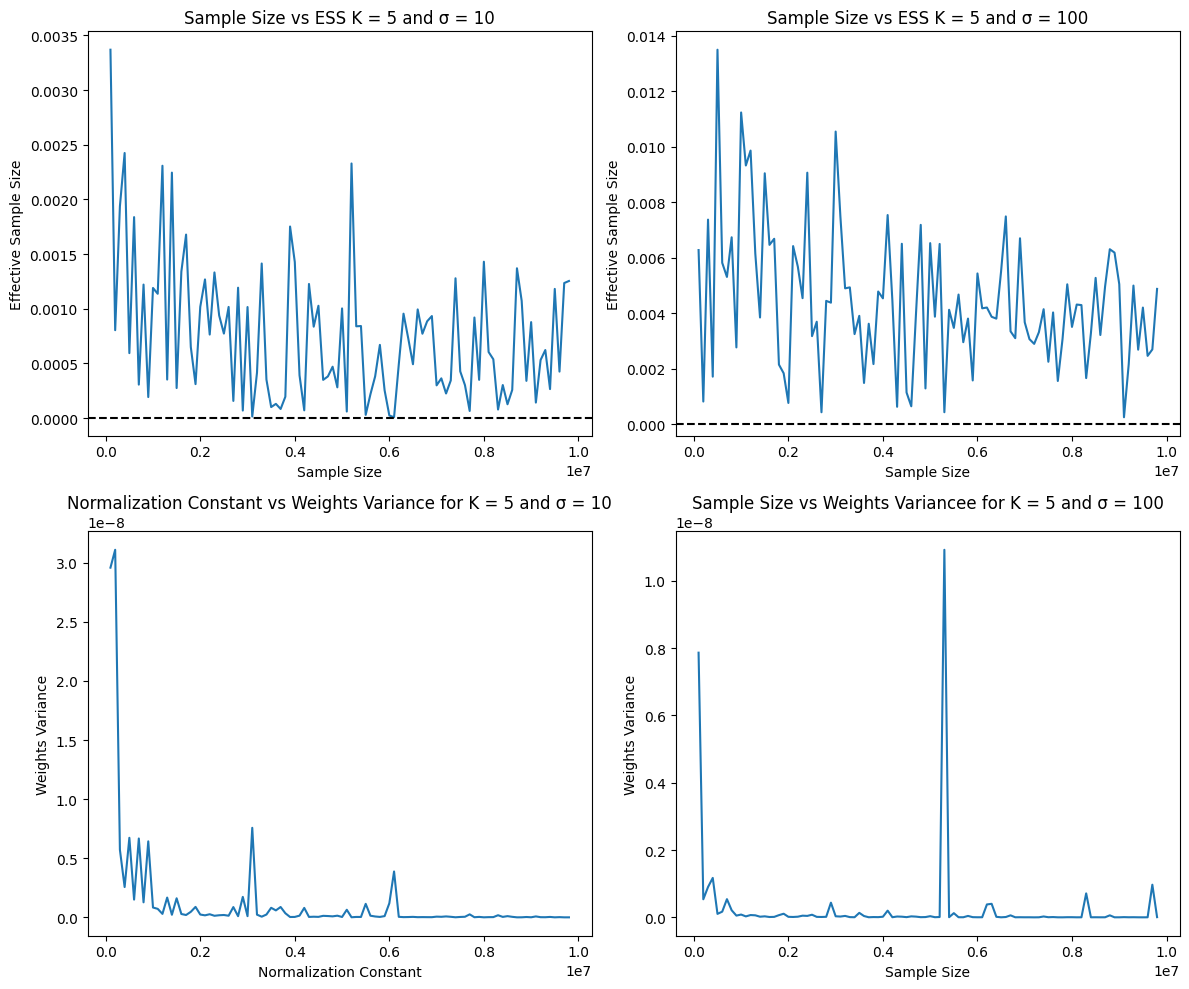

In [ ]:
# Sample data for sigma = 10
s_25_10 = [w_25_10[i]['sample_size'] for i in range(98)]
e_25_10 = [w_25_10[i]['ess']  for i in range(98)]
w_25_10 = [w_25_10[i]['weights_variance'] for i in range(98)]

s_25_100 = [w_25_100[i]['sample_size'] for i in range(98)]
e_25_100 = [w_25_100[i]['ess']  for i in range(98)]
w_25_100 = [w_25_100[i]['weights_variance'] for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Upper left plot: Sample size vs Execution time
axs[0, 0].plot(s_25_10, e_25_10)
axs[0, 0].set_title('Sample Size vs ESS K = 5 and \u03C3 = 10')
axs[0, 0].set_xlabel('Sample Size')
axs[0, 0].set_ylabel('Effective Sample Size')
axs[0, 0].grid(False)
axs[0, 0].axhline(y=0, color='black', linestyle='--')  

# Upper right plot: Sample size vs Normalization constant
axs[0, 1].plot(s_25_100, e_25_100)
axs[0, 1].set_title('Sample Size vs ESS K = 5 and \u03C3 = 100')
axs[0, 1].set_xlabel('Sample Size')
axs[0, 1].set_ylabel('Effective Sample Size')
axs[0, 1].grid(False)
axs[0, 1].axhline(y=0, color='black', linestyle='--')  


# Lower left plot: Normalization constant vs Execution time
axs[1, 0].plot(s_25_10, w_25_10)
axs[1, 0].set_title('Normalization Constant vs Weights Variance for K = 5 and \u03C3 = 10')
axs[1, 0].set_xlabel('Normalization Constant')
axs[1, 0].set_ylabel('Weights Variance')
axs[1, 0].grid(False)

# Lower right plot: Sample size vs Sample size (placeholder)
axs[1, 1].plot(s_25_100, w_5_100)
axs[1, 1].set_title('Sample Size vs Weights Variancee for K = 5 and \u03C3 = 100')
axs[1, 1].set_xlabel('Sample Size')
axs[1, 1].set_ylabel('Weights Variance')
axs[1, 1].grid(False)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

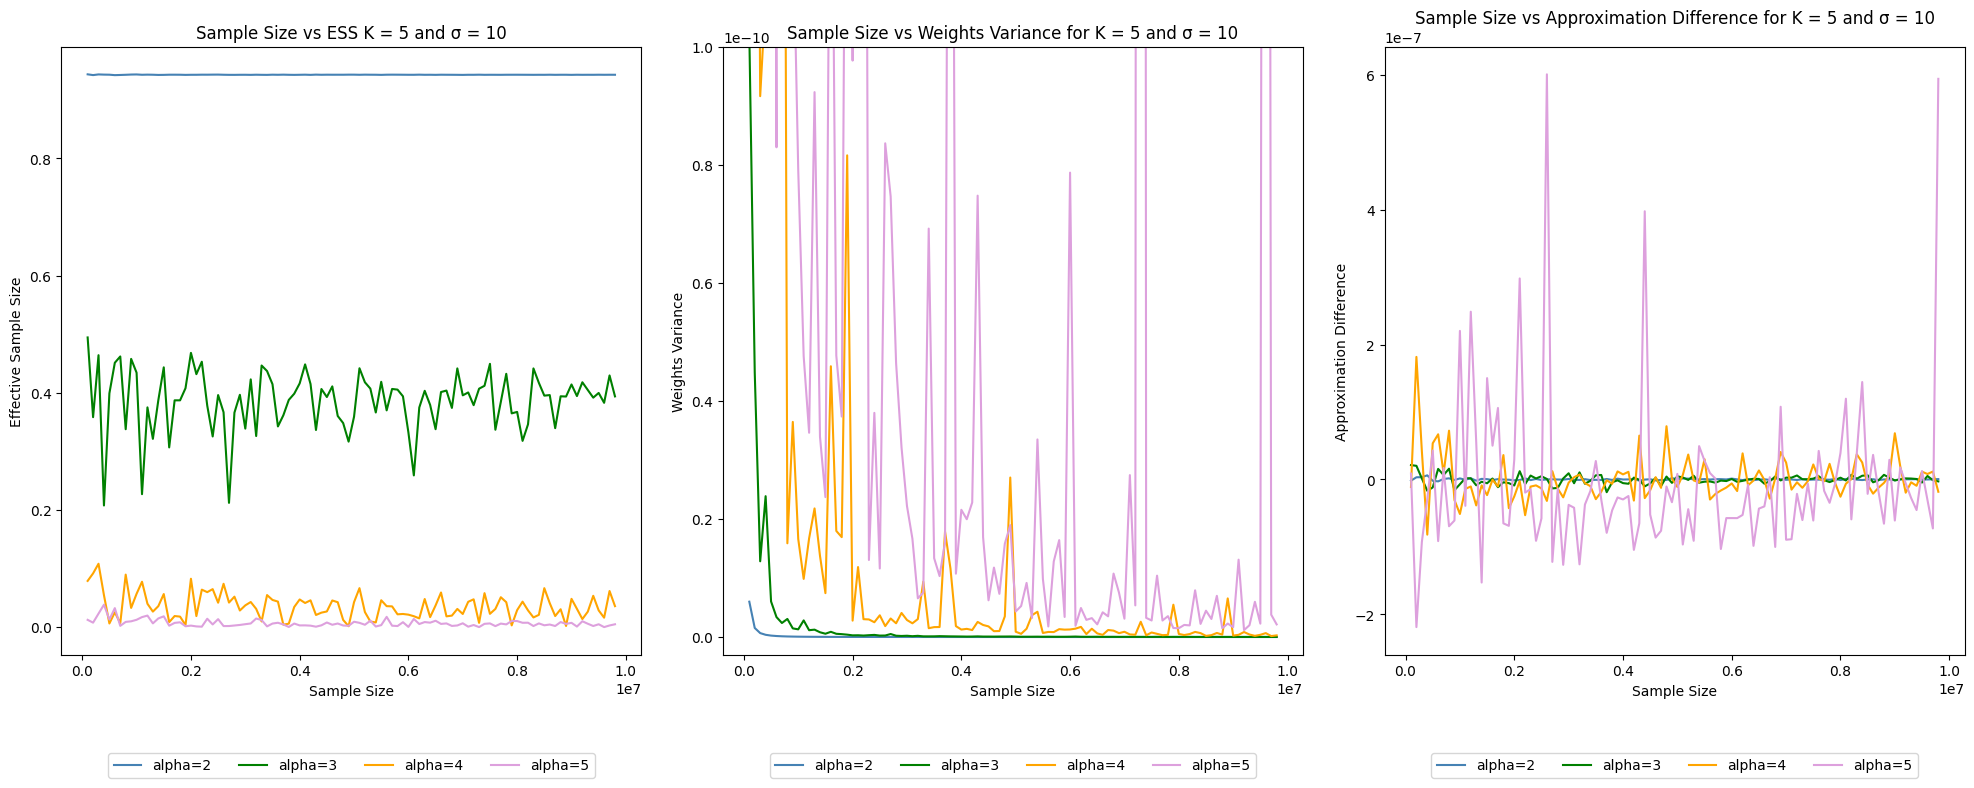

In [248]:
# Sample size
s_1 = [w_25_10_2[i]['sample_size'] for i in range(98)]

# ess
e_1 = [w_5_10_2[i]['ess']  for i in range(98)]
e_2 = [w_5_10_3[i]['ess']  for i in range(98)]
e_3 = [w_5_10_4[i]['ess']  for i in range(98)]
e_4 = [w_5_10_5[i]['ess']  for i in range(98)]

# var
v_1 = [w_5_10_2[i]['weights_variance'] for i in range(98)]
v_2 = [w_5_10_3[i]['weights_variance'] for i in range(98)]
v_3 = [w_5_10_4[i]['weights_variance'] for i in range(98)]
v_4 = [w_5_10_5[i]['weights_variance'] for i in range(98)]

# diff 
d_1 = [mc_imp_5_10_2[i]['normalization_constant'] - 7.24859e-06 for i in range(98)]
d_2 = [mc_imp_5_10_3[i]['normalization_constant'] - 7.24859e-06 for i in range(98)]
d_3 = [mc_imp_5_10_4[i]['normalization_constant'] - 7.24859e-06 for i in range(98)]
d_4 = [mc_imp_5_10_5[i]['normalization_constant'] - 7.24859e-06 for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Upper left plot: Sample size vs ESS K = 5 and σ = 10
axs[0].plot(s_1, e_1, color='steelblue', label='alpha=2')  # Line with alpha=2
axs[0].plot(s_1, e_2, color='green', label='alpha=3')  # Line with alpha=3
axs[0].plot(s_1, e_3, color='orange', label='alpha=4')  # Line with alpha=4
axs[0].plot(s_1, e_4, color='plum', label='alpha=5')  # Line with alpha=5
axs[0].set_title('Sample Size vs ESS K = 5 and \u03C3 = 10')
axs[0].set_xlabel('Sample Size')
axs[0].set_ylabel('Effective Sample Size')
axs[0].grid(False)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper middle plot: Sample size vs Weights Variance for K = 5 and σ = 10
axs[1].plot(s_1, v_1, color='steelblue', label='alpha=2')
axs[1].plot(s_1, v_2, color='green', label='alpha=3')
axs[1].plot(s_1, v_3, color='orange', label='alpha=4')
axs[1].plot(s_1, v_4, color='plum', label='alpha=5')
axs[1].set_title('Sample Size vs Weights Variance for K = 5 and \u03C3 = 10')
axs[1].set_xlabel('Sample Size')
axs[1].set_ylabel('Weights Variance')
axs[1].set_ylim(-3e-12, 1e-10)
axs[1].grid(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper right plot: Sample size vs Approximation Difference for K = 5 and σ = 10
axs[2].plot(s_1, d_1, color='steelblue', label='alpha=2')
axs[2].plot(s_1, d_2, color='green', label='alpha=3')
axs[2].plot(s_1, d_3, color='orange', label='alpha=4')
axs[2].plot(s_1, d_4, color='plum', label='alpha=5')
axs[2].set_title('Sample Size vs Approximation Difference for K = 5 and \u03C3 = 10')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('Approximation Difference')
axs[2].grid(False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

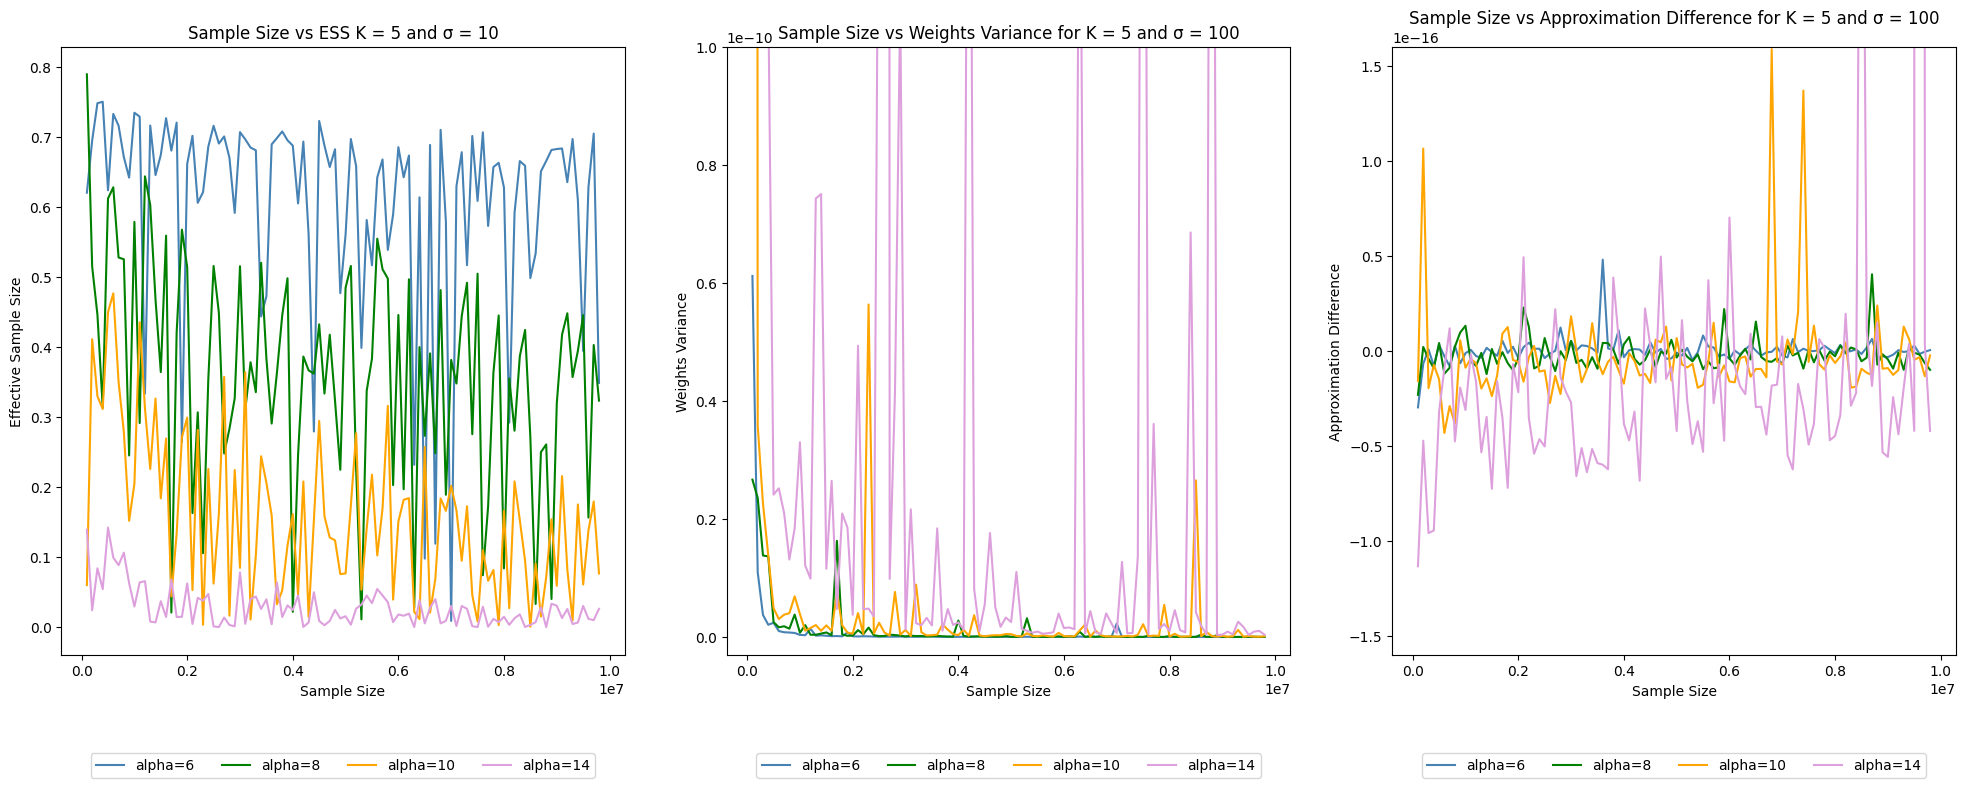

In [234]:
# Sample size
s_1 = [w_25_10_2[i]['sample_size'] for i in range(98)]

# ess
e_1 = [w_5_100_6[i]['ess']  for i in range(98)]
e_2 = [w_5_100_8[i]['ess']  for i in range(98)]
e_3 = [w_5_100_10[i]['ess']  for i in range(98)]
e_4 = [w_5_100_14[i]['ess']  for i in range(98)]

# var
v_1 = [w_5_100_6[i]['weights_variance'] for i in range(98)]
v_2 = [w_5_100_8[i]['weights_variance'] for i in range(98)]
v_3 = [w_5_100_10[i]['weights_variance'] for i in range(98)]
v_4 = [w_5_100_14[i]['weights_variance'] for i in range(98)]

# diff 
d_1 = [mc_imp_5_100_6[i]['normalization_constant'] - 6.12239e-15 for i in range(98)]
d_2 = [mc_imp_5_100_8[i]['normalization_constant'] - 6.12239e-15 for i in range(98)]
d_3 = [mc_imp_5_100_10[i]['normalization_constant'] - 6.12239e-15 for i in range(98)]
d_4 = [mc_imp_5_100_14[i]['normalization_constant'] - 6.12239e-15 for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Upper left plot: Sample size vs ESS K = 5 and σ = 10
axs[0].plot(s_1, e_1, color='steelblue', label='alpha=6')  # Line with alpha=2
axs[0].plot(s_1, e_2, color='green', label='alpha=8')  # Line with alpha=3
axs[0].plot(s_1, e_3, color='orange', label='alpha=10')  # Line with alpha=4
axs[0].plot(s_1, e_4, color='plum', label='alpha=14')  # Line with alpha=5
axs[0].set_title('Sample Size vs ESS K = 5 and \u03C3 = 10')
axs[0].set_xlabel('Sample Size')
axs[0].set_ylabel('Effective Sample Size')
axs[0].grid(False)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper middle plot: Sample size vs Weights Variance for K = 5 and σ = 100
axs[1].plot(s_1, v_1, color='steelblue', label='alpha=6')
axs[1].plot(s_1, v_2, color='green', label='alpha=8')
axs[1].plot(s_1, v_3, color='orange', label='alpha=10')
axs[1].plot(s_1, v_4, color='plum', label='alpha=14')
axs[1].set_title('Sample Size vs Weights Variance for K = 5 and \u03C3 = 100')
axs[1].set_xlabel('Sample Size')
axs[1].set_ylabel('Weights Variance')
axs[1].set_ylim(-3e-12, 1e-10)
axs[1].grid(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper right plot: Sample size vs Approximation Difference for K = 5 and σ = 100
axs[2].plot(s_1, d_1, color='steelblue', label='alpha=6')
axs[2].plot(s_1, d_2, color='green', label='alpha=8')
axs[2].plot(s_1, d_3, color='orange', label='alpha=10')
axs[2].plot(s_1, d_4, color='plum', label='alpha=14')
axs[2].set_title('Sample Size vs Approximation Difference for K = 5 and \u03C3 = 100')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('Approximation Difference')
axs[2].set_ylim( -1.6e-16, 1.6e-16 )
axs[2].grid(False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

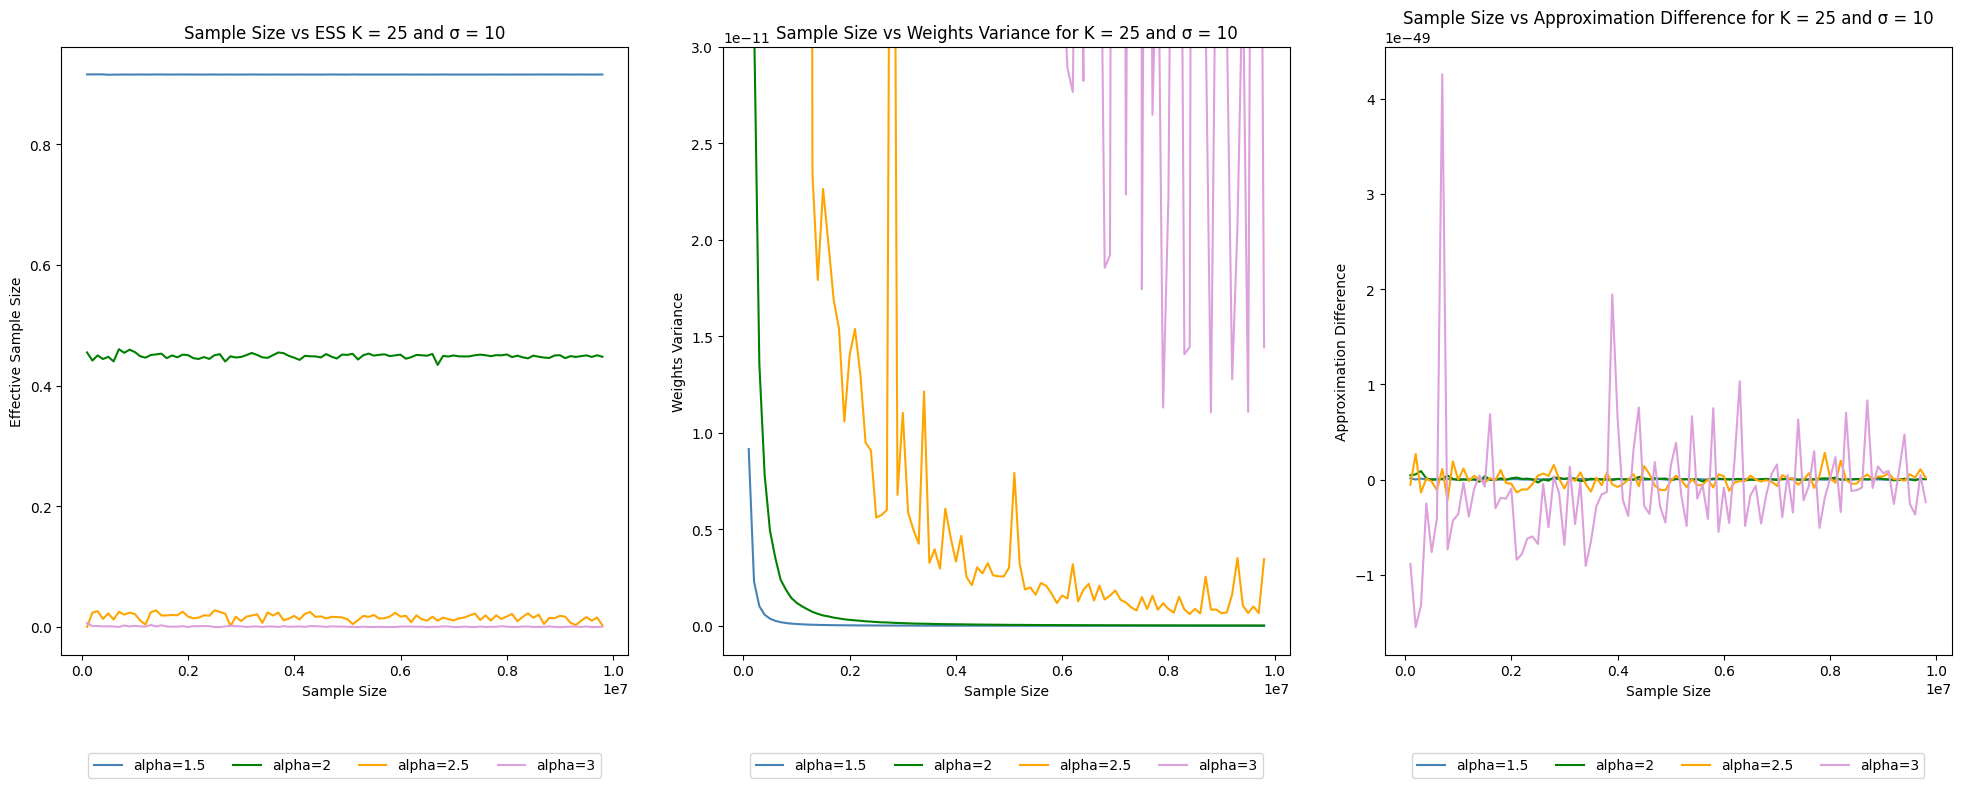

In [245]:
# Sample size
s_1 = [w_25_10_2[i]['sample_size'] for i in range(98)]

# ess
e_1 = [w_25_10_1_5[i]['ess']  for i in range(98)]
e_2 = [w_25_10_2[i]['ess']  for i in range(98)]
e_3 = [w_25_10_2_5[i]['ess']  for i in range(98)]
e_4 = [w_25_10_3[i]['ess']  for i in range(98)]

# var
v_1 = [w_25_10_1_5[i]['weights_variance'] for i in range(98)]
v_2 = [w_25_10_2[i]['weights_variance'] for i in range(98)]
v_3 = [w_25_10_2_5[i]['weights_variance'] for i in range(98)]
v_4 = [w_25_10_3[i]['weights_variance'] for i in range(98)]

# diff 
d_1 = [mc_imp_25_10_1_5[i]['normalization_constant'] - 1.56272e-48 for i in range(98)]
d_2 = [mc_imp_25_10_2[i]['normalization_constant'] - 1.56272e-48 for i in range(98)]
d_3 = [mc_imp_25_10_2_5[i]['normalization_constant'] - 1.56272e-48 for i in range(98)]
d_4 = [mc_imp_25_10_3[i]['normalization_constant'] - 1.56272e-48 for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Upper left plot: Sample size vs ESS K = 5 and σ = 10
axs[0].plot(s_1, e_1, color='steelblue', label='alpha=1.5')  # Line with alpha=2
axs[0].plot(s_1, e_2, color='green', label='alpha=2')  # Line with alpha=3
axs[0].plot(s_1, e_3, color='orange', label='alpha=2.5')  # Line with alpha=4
axs[0].plot(s_1, e_4, color='plum', label='alpha=3')  # Line with alpha=5
axs[0].set_title('Sample Size vs ESS K = 25 and \u03C3 = 10')
axs[0].set_xlabel('Sample Size')
axs[0].set_ylabel('Effective Sample Size')
axs[0].grid(False)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper middle plot: Sample size vs Weights Variance for K = 5 and σ = 10
axs[1].plot(s_1, v_1, color='steelblue', label='alpha=1.5')
axs[1].plot(s_1, v_2, color='green', label='alpha=2')
axs[1].plot(s_1, v_3, color='orange', label='alpha=2.5')
axs[1].plot(s_1, v_4, color='plum', label='alpha=3')
axs[1].set_title('Sample Size vs Weights Variance for K = 25 and \u03C3 = 10')
axs[1].set_xlabel('Sample Size')
axs[1].set_ylabel('Weights Variance')
axs[1].set_ylim(-1.5e-12, 3e-11)
axs[1].grid(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper right plot: Sample size vs Approximation Difference for K = 5 and σ = 10
axs[2].plot(s_1, d_1, color='steelblue', label='alpha=1.5')
axs[2].plot(s_1, d_2, color='green', label='alpha=2')
axs[2].plot(s_1, d_3, color='orange', label='alpha=2.5')
axs[2].plot(s_1, d_4, color='plum', label='alpha=3')
axs[2].set_title('Sample Size vs Approximation Difference for K = 25 and \u03C3 = 10')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('Approximation Difference')
axs[2].grid(False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

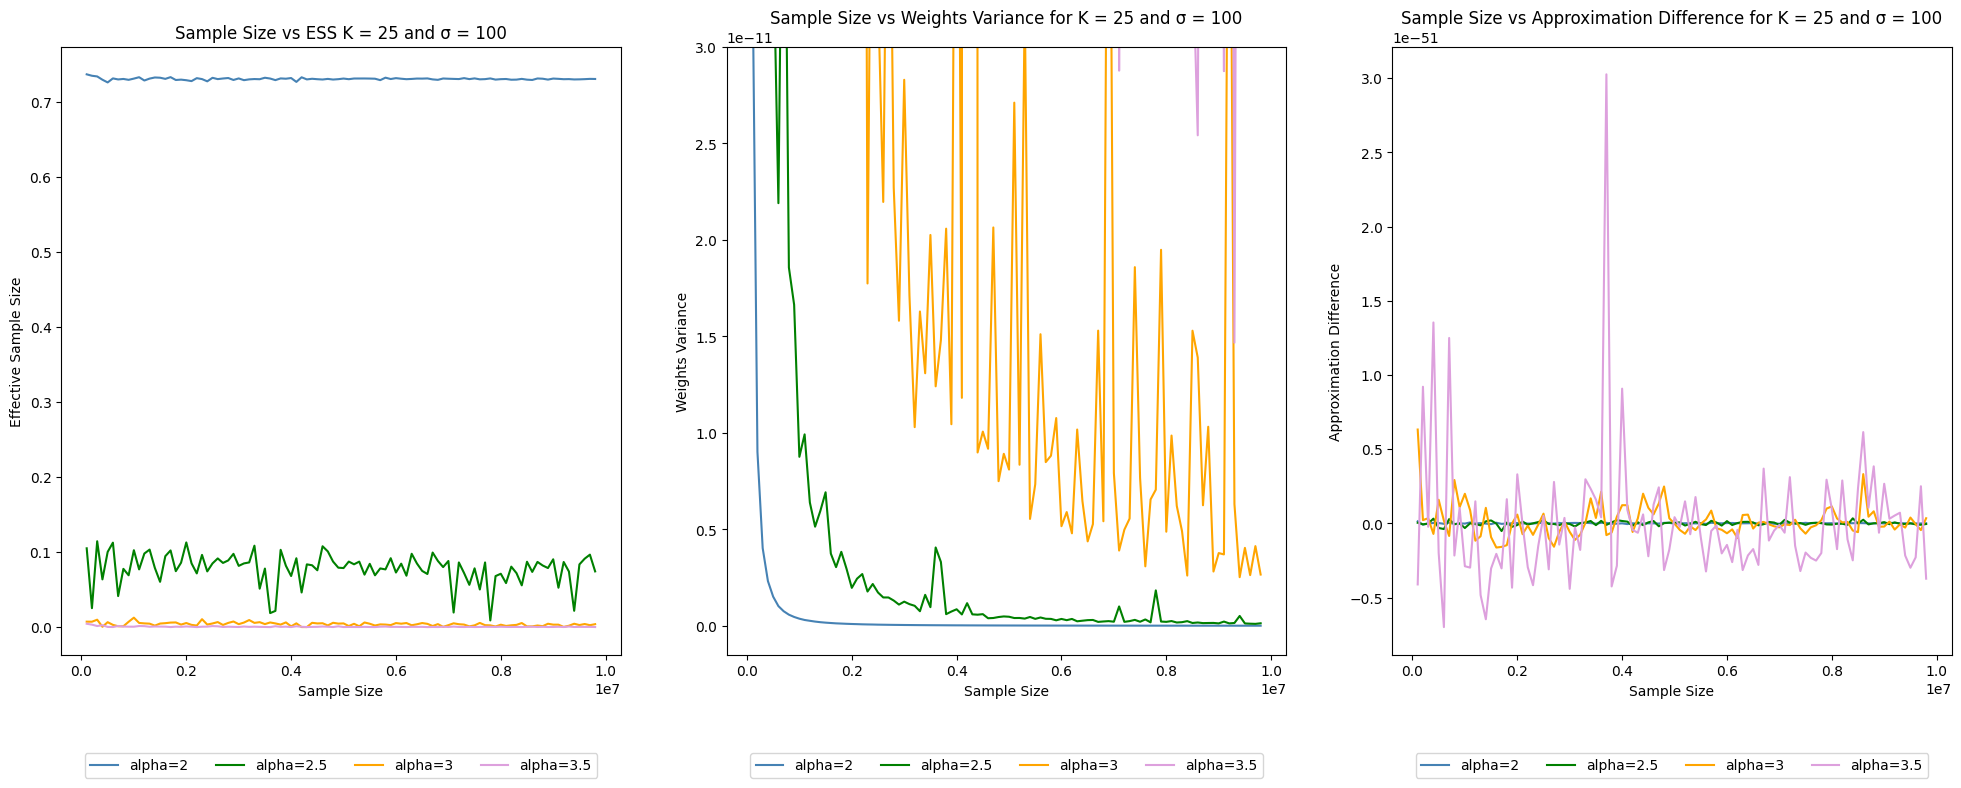

In [255]:
# Sample size
s_1 = [w_25_10_2[i]['sample_size'] for i in range(98)]

# ess
e_1 = [w_25_100_2[i]['ess']  for i in range(98)]
e_2 = [w_25_100_2_5[i]['ess']  for i in range(98)]
e_3 = [w_25_100_3[i]['ess']  for i in range(98)]
e_4 = [w_25_100_3_5[i]['ess']  for i in range(98)]

# var
v_1 = [w_25_100_2[i]['weights_variance'] for i in range(98)]
v_2 = [w_25_100_2_5[i]['weights_variance'] for i in range(98)]
v_3 = [w_25_100_3[i]['weights_variance'] for i in range(98)]
v_4 = [w_25_100_3_5[i]['weights_variance'] for i in range(98)]

# diff 
d_1 = [mc_imp_25_100_2[i]['normalization_constant'] - 6.66084e-51 for i in range(98)]
d_2 = [mc_imp_25_100_2_5[i]['normalization_constant'] - 6.66084e-51 for i in range(98)]
d_3 = [mc_imp_25_100_3[i]['normalization_constant'] - 6.66084e-51 for i in range(98)]
d_4 = [mc_imp_25_100_3_5[i]['normalization_constant'] - 6.66084e-51 for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Upper left plot: Sample size vs ESS K = 5 and σ = 10
axs[0].plot(s_1, e_1, color='steelblue', label='alpha=2')  # Line with alpha=2
axs[0].plot(s_1, e_2, color='green', label='alpha=2.5')  # Line with alpha=3
axs[0].plot(s_1, e_3, color='orange', label='alpha=3')  # Line with alpha=4
axs[0].plot(s_1, e_4, color='plum', label='alpha=3.5')  # Line with alpha=5
axs[0].set_title('Sample Size vs ESS K = 25 and \u03C3 = 100')
axs[0].set_xlabel('Sample Size')
axs[0].set_ylabel('Effective Sample Size')
axs[0].grid(False)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper middle plot: Sample size vs Weights Variance for K = 5 and σ = 10
axs[1].plot(s_1, v_1, color='steelblue', label='alpha=2')
axs[1].plot(s_1, v_2, color='green', label='alpha=2.5')
axs[1].plot(s_1, v_3, color='orange', label='alpha=3')
axs[1].plot(s_1, v_4, color='plum', label='alpha=3.5')
axs[1].set_title('Sample Size vs Weights Variance for K = 25 and \u03C3 = 100')
axs[1].set_xlabel('Sample Size')
axs[1].set_ylabel('Weights Variance')
axs[1].set_ylim(-1.5e-12, 3e-11)
axs[1].grid(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Upper right plot: Sample size vs Approximation Difference for K = 5 and σ = 10
axs[2].plot(s_1, d_1, color='steelblue', label='alpha=2')
axs[2].plot(s_1, d_2, color='green', label='alpha=2.5')
axs[2].plot(s_1, d_3, color='orange', label='alpha=3')
axs[2].plot(s_1, d_4, color='plum', label='alpha=3.5')
axs[2].set_title('Sample Size vs Approximation Difference for K = 25 and \u03C3 = 100')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('Approximation Difference')
axs[2].grid(False)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Move legend below plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

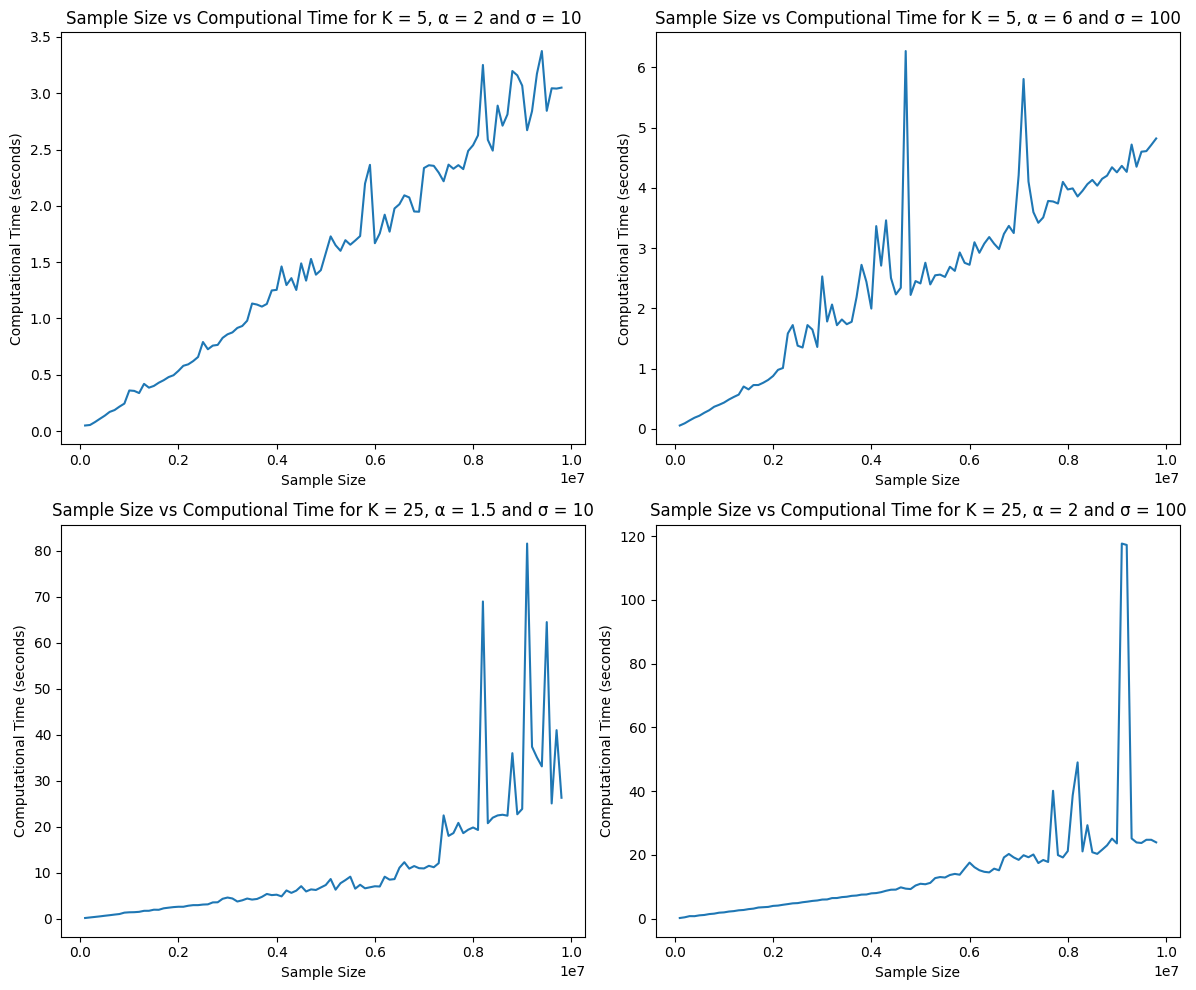

In [ ]:
# Sample sizes
s = [w_25_100_2[i]['sample_size'] for i in range(98)]

# computational times 
t_1 = [mc_imp_5_10_2[i]['execution_time'] for i in range(98)]
t_2 = [mc_imp_5_100_6[i]['execution_time'] for i in range(98)]
t_3 = [mc_imp_25_10_1_5[i]['execution_time'] for i in range(98)]
t_4 = [mc_imp_25_100_2[i]['execution_time'] for i in range(98)]

# Create the figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Upper left plot: Sample size vs Execution time
axs[0, 0].plot(s, t_1)
axs[0, 0].set_title('Sample Size vs Computional Time for K = 5, \u03B1 = 2 and \u03C3 = 10')
axs[0, 0].set_xlabel('Sample Size')
axs[0, 0].set_ylabel('Computational Time (seconds)')
axs[0, 0].grid(False)
 

# Upper right plot: Sample size vs Normalization constant
axs[0, 1].plot(s, t_2)
axs[0, 1].set_title('Sample Size vs Computional Time for K = 5, \u03B1 = 6 and \u03C3 = 100')
axs[0, 1].set_xlabel('Sample Size')
axs[0, 1].set_ylabel('Computational Time (seconds)')
axs[0, 1].grid(False)
 



# Lower left plot: Normalization constant vs Execution time
axs[1, 0].plot(s, t_3)
axs[1, 0].set_title('Sample Size vs Computional Time for K = 25, \u03B1 = 1.5 and \u03C3 = 10')
axs[1, 0].set_xlabel('Sample Size')
axs[1, 0].set_ylabel('Computational Time (seconds)')
axs[1, 0].grid(False)
 


# Lower right plot: Sample size vs Sample size (placeholder)
axs[1, 1].plot(s, t_4)
axs[1, 1].set_title('Sample Size vs Computional Time for K = 25, \u03B1 = 2 and \u03C3 = 100')
axs[1, 1].set_xlabel('Sample Size')
axs[1, 1].set_ylabel('Computational Time (seconds)')
axs[1, 1].grid(False)
 



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()